In [1]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hdbscan 0.8.41 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
umap-learn 0.5.11 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [205]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')


In [206]:
# Using log transformations

log_cols = [
    "price",
    "sqft_living",
    "sqft_lot",
    "sqft_above",
    "sqft_basement"
]

for col in log_cols:
    df[f"log_{col}"] = np.log1p(df[col])

df = df.drop(columns=log_cols + ["id"]) # ID was useless

In [207]:
# Transforming date into useable features. Also renoveted needed some help, data wise, when a house was not renovated.

df["date"] = pd.to_datetime(df["date"], format="%Y%m%dT%H%M%S")
df["sale_year"] = df["date"].dt.year
df["sale_month"] = df["date"].dt.month
df = df.drop(columns=["date"])

df["renovated"] = (df["yr_renovated"] > 0).astype(int)

In [208]:
X = df.drop(columns=["log_price"]) # All but log_price (also not ID).
y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2 # 20% of the dataset will go into the test set.
)

In [209]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [210]:
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 5, # tree sizing
    "min_child_weight": 5, # tree sizing
    "subsample": 0.8, # 80% of the training data randomly sampled
    "colsample_bytree": 0.8, # each tree sees 80% of the features randomly sampled
    "seed": 42 # makes my number stop moving.
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000, # end at 1000 trees
    evals=[(dtest, "valid")],
    early_stopping_rounds=50, # end training if the validation metric does not improve for 50 consecutive rounds.
    verbose_eval=False
)


In [211]:
log_preds = model.predict(dtest)
price_preds = np.expm1(log_preds)

rmse = root_mean_squared_error(
    np.expm1(y_test),
    price_preds
)

print(f"RMSE: ${rmse:,.0f}")


RMSE: $105,302


In [212]:
print(X_train.shape, X_test.shape)
print(y_train.min(), y_train.max())


(16000, 21) (4000, 21)
11.225256725762893 15.856731016694035


In [213]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtest, "valid")],
    early_stopping_rounds=50,
    verbose_eval=50
)


[0]	valid-rmse:0.50689
[50]	valid-rmse:0.20206
[100]	valid-rmse:0.17880
[150]	valid-rmse:0.17267
[200]	valid-rmse:0.16889
[250]	valid-rmse:0.16682
[300]	valid-rmse:0.16553
[350]	valid-rmse:0.16438
[400]	valid-rmse:0.16357
[450]	valid-rmse:0.16288
[500]	valid-rmse:0.16221
[550]	valid-rmse:0.16179
[600]	valid-rmse:0.16138
[650]	valid-rmse:0.16135
[700]	valid-rmse:0.16113
[750]	valid-rmse:0.16107
[800]	valid-rmse:0.16069
[850]	valid-rmse:0.16064
[900]	valid-rmse:0.16061
[928]	valid-rmse:0.16066


In [ ]:
# grade, sqft_living, zipcode, long, sqft_lot, view, sqft_living,

<Figure size 20000x20000 with 0 Axes>

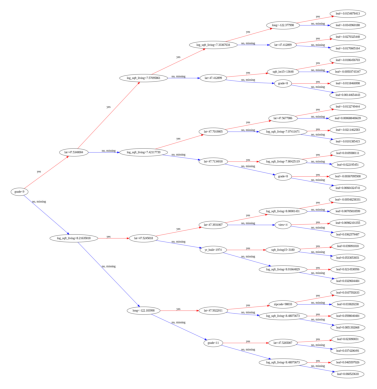

In [214]:
import matplotlib.pyplot as plt

plt.figure(figsize=(200, 200))
xgb.plot_tree(model, rankdir='LR')
plt.show()